In [1]:
import os
import copy
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

In [2]:
############################################
# 1) Функции для нарезки и подготовки
############################################


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)
    l_idx = int((N_samples * num_of_part) / N_parts)
    return data[:l_idx], data[l_idx:]


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    ts_samp = int((timestep * fs) / 1000)
    wl_samp = int((windowlen * fs) / 1000)
    start = np.arange(0, data_len - wl_samp, ts_samp)[:, None]
    idxs = start + np.arange(0, wl_samp)[None, :]
    X = data[idxs].transpose(0, 2, 1)
    y = label[start[:, 0] + wl_samp]
    return X, y


def prepare_sequences(X: np.ndarray, y: np.ndarray, seq_len: int):
    # X: (T, feat_dim), y: (T, out_dim)
    T, feat = X.shape
    _, out = y.shape
    n_seq = T - seq_len + 1
    Xs = np.zeros((n_seq, seq_len, feat), dtype=X.dtype)
    Ys = np.zeros((n_seq, seq_len, out), dtype=y.dtype)
    for i in range(n_seq):
        Xs[i] = X[i : i + seq_len]
        Ys[i] = y[i : i + seq_len]
    return Xs, Ys


def prepare_single_sequence(X: np.ndarray, seq_len: int):
    T, feat = X.shape
    if T < seq_len:
        pad = np.zeros((seq_len - T, feat), dtype=X.dtype)
        X = np.vstack([pad, X])
    return X[None, -seq_len:, :]


def contains_any_substring(s, substrings):
    return any(sub in s for sub in substrings)

#### Fedor

In [4]:
subj_path = "..\\data\\Fedor\\Preprocessed\\1\\"
n_files = 4
n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for i in range(n_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1420, 6, 128), (353, 6, 128), (1420, 20), (353, 20))

In [ ]:
############################################
# 2) Пример запуска — подготовка данных
############################################

# Параметры
subj_path = "../data/Fedor_Jan/Preprocessed/"
files = sorted(os.listdir(subj_path))
n_parts = 10
train_num_of_part = 8
fs = 250

# Списки
data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

for fname in files:
    arr = np.load(os.path.join(subj_path, fname))
    data, label = arr["data_myo"], arr["data_angles"]  # (T, ch), (T, 20)
    dt, dtest = train_test_split(data, n_parts, train_num_of_part)
    lt, ltest = train_test_split(label, n_parts, train_num_of_part)
    data_list_train.append(dt)
    label_list_train.append(lt)
    data_list_test.append(dtest)
    label_list_test.append(ltest)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (27743, 8, 128) → (27743, 20)
Test  windows: (6935, 8, 128) → (6935, 20)


In [17]:
############################################
# 2) Пример запуска — выбор данных на
# обучение и валидацию вручную
############################################

# Параметры
subj_path = "../data/Fedor_Jan/Preprocessed/"
files = sorted(os.listdir(subj_path))
n_parts = 10
train_num_of_part = 8
fs = 250

# Списки
data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Simple2_4"]
train_files_subnames = [
    # "Simple2_1",
    # "Simple2_2",
    "Simple2_3",
    "Simple1_1",
    "Simple1_2",
    "Simple1_3",
    "Simple1_4",
    "Simple1_5",
]


for fname in files:
    arr = np.load(os.path.join(subj_path, fname))
    data, label = arr["data_myo"], arr["data_angles"]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (21341, 8, 128) → (21341, 20)
Test  windows: (3555, 8, 128) → (3555, 20)


#### Oleg

In [3]:
subj_path = "..\\data\\Oleg\\Preprocessed\\Simple1\\5\\"
n_files = 4
n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for i in range(n_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1421, 8, 128), (354, 8, 128), (1421, 20), (354, 20))

In [4]:
root_dir = r"D:\study\myo\emg-virtual\data\Oleg\Preprocessed\Simple1"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

fs = 250
n_channels = 8

data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Simple1\\3"]
train_files_subnames = ["Simple1\\2", "Simple1\\4", "Simple1\\5"]

for fname in files:
    arr = np.load(fname)
    data, label = arr["data_myo"], arr["data_angles"]
    data = data[:, :n_channels]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (8892, 8, 128) → (8892, 20)
Test  windows: (3556, 8, 128) → (3556, 20)


#### Nastya

In [43]:
root_dir = r"D:\study\myo\emg-virtual\data\Nastya\Simple\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

fs = 250
n_channels = 8

data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Simple3\\3"]

train_files_subnames = [
    "Simple1\\1",
    "Simple1\\3",
    "Simple1\\4",
    "Simple1\\5",
    "Simple2\\1",
    "Simple2\\2",
    "Simple2\\3",
    "Simple3\\1",
    "Simple3\\2",
    "Simple3\\4",
    "Simple3\\5",
    "Simple4\\1",
    "Simple4\\2",
    "Simple4\\4",
    "Simple4\\5",
]

for fname in files:
    arr = np.load(fname)
    data, label = arr["data_myo"], arr["data_angles"]
    data = data[:, :n_channels]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (53367, 8, 128) → (53367, 20)
Test  windows: (3561, 8, 128) → (3561, 20)


#### Model

In [44]:
# 3) Определяем LSTM-модель с авторегрессией
############################################


# class EMGDecoderLSTM(nn.Module):
#     def __init__(self, feat_dim: int, hidden_dim: int, output_dim: int):
#         super().__init__()
#         # LSTMCell — шаг авторегрессии
#         self.lstm_cell = nn.LSTMCell(feat_dim + output_dim, hidden_dim)
#         self.mlp = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.GELU(),
#             nn.Linear(hidden_dim, output_dim),
#         )
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim

#     def forward_step(
#         self,
#         features: torch.Tensor,
#         prev_output: torch.Tensor,
#         hidden: torch.Tensor = None,
#         cell: torch.Tensor = None,
#     ):
#         # features: (batch, feat_dim)
#         # prev_output: (batch, output_dim)
#         # hidden: (batch, hidden_dim) или None
#         # hidden: (batch, hidden_dim) или None
#         batch_size = features.size(0)
#         device = features.device

#         if hidden is None:
#             hidden = torch.zeros(batch_size, self.hidden_dim, device=device)

#         if cell is None:
#             cell = torch.zeros(batch_size, self.hidden_dim, device=device)

#         inp = torch.cat([features, prev_output], dim=1)  # (batch, feat+out)
#         new_hidden, new_cell = self.lstm_cell(
#             inp, (hidden, cell)
#         )  # (batch, hidden_dim)
#         pred = self.mlp(new_hidden)  # (batch, output_dim)
#         return pred, new_hidden, new_cell


class EMGDecoderLSTM(nn.Module):
    def __init__(self, feat_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        # LSTMCell — шаг авторегрессии
        self.linear = nn.Linear(feat_dim + output_dim, hidden_dim)
        self.lstm_cell = nn.LSTMCell(hidden_dim, hidden_dim)
        self.mlp = nn.Sequential(
            # nn.Linear(hidden_dim, hidden_dim),
            # nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
        )
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

    def forward_step(
        self,
        features: torch.Tensor,
        prev_output: torch.Tensor,
        hidden: torch.Tensor = None,
        cell: torch.Tensor = None,
    ):
        batch_size = features.size(0)
        device = features.device

        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_dim, device=device)

        if cell is None:
            cell = torch.zeros(batch_size, self.hidden_dim, device=device)

        inp = torch.cat([features, prev_output], dim=1)  # (batch, feat+out)
        inp = self.linear(inp)
        new_hidden, new_cell = self.lstm_cell(
            inp, (hidden, cell)
        )  # (batch, hidden_dim)
        pred = self.mlp(new_hidden)  # (batch, output_dim)
        return pred, new_hidden, new_cell


# class EMGDecoderLSTM(nn.Module):
#     def __init__(self, feat_dim: int, hidden_dim: int, output_dim: int):
#         super().__init__()
#         # LSTMCell — шаг авторегрессии
#         self.lstm_cell_emg = nn.LSTMCell(feat_dim, hidden_dim)
#         self.lstm_cell_output = nn.LSTMCell(output_dim, hidden_dim)

#         self.mlp = nn.Sequential(
#             nn.Linear(hidden_dim + hidden_dim, hidden_dim // 2),
#             nn.GELU(),
#             nn.Linear(hidden_dim // 2, output_dim),
#         )
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim

#     def forward_step(
#         self,
#         features: torch.Tensor,
#         prev_output: torch.Tensor,
#         hidden_emg: torch.Tensor = None,
#         cell_emg: torch.Tensor = None,
#         hidden_output: torch.Tensor = None,
#         cell_output: torch.Tensor = None,
#     ):
#         batch_size = features.size(0)
#         device = features.device

#         if hidden_emg is None or hidden_output is None:
#             hidden_emg = torch.zeros(batch_size, self.hidden_dim, device=device)
#             hidden_output = torch.zeros(batch_size, self.hidden_dim, device=device)

#         if cell_emg is None or cell_output is None:
#             cell_emg = torch.zeros(batch_size, self.hidden_dim, device=device)
#             cell_output = torch.zeros(batch_size, self.hidden_dim, device=device)

#         new_hidden_emg, new_cell_emg = self.lstm_cell_emg(
#             features, (hidden_emg, cell_emg)
#         )
#         new_hidden_output, new_cell_output = self.lstm_cell_output(
#             prev_output, (hidden_output, cell_output)
#         )
#         inp = torch.cat([new_hidden_emg, new_hidden_output], dim=1)
#         pred = self.mlp(inp)
#         return pred, new_hidden_emg, new_cell_emg, new_hidden_output, new_cell_output

In [45]:
# 4) Обёртка-регрессор
############################################


class RiemannLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator: str = "oas",
        metric: str = "riemann",
        hidden_dim: int = 64,
        seq_len: int = 20,
        lr: float = 1e-3,
        alpha: float = 1e-5,
        max_iter: int = 50,
        batch_size: int = 32,
        device: str = "cpu",
        verbose: bool = False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.lr = lr
        self.alpha = alpha
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose

        # будут инициализированы в fit
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X: np.ndarray, y: np.ndarray, X_val=None, y_val=None):
        # X: (n_windows, n_ch, n_time), y: (n_windows, 20)
        # 1) Riemann-признаки
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)  # (T, feat_dim)

        # 2) Переход к numpy, чтобы сформировать sequences
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        # X_seq: (n_seq, seq_len, feat); y_seq: (n_seq, seq_len, 20)

        # 3) В даталоадер подаём X_seq и y_seq
        # Сшиваем по последнему измерению: для каждой позиции t обучаем модель последовательно
        # но DataLoader вернёт полный seq.
        dataset = TensorDataset(
            torch.tensor(X_seq, dtype=torch.float32),
            torch.tensor(y_seq, dtype=torch.float32),
        )
        loader = DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True, drop_last=True
        )

        # 4) Создаём модель
        feat_dim = X_ts.shape[1]
        output_dim = y.shape[1]
        self.model_ = EMGDecoderLSTM(feat_dim, self.hidden_dim, output_dim).to(
            self.device
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=self.max_iter // 2, gamma=0.7
        )

        best_val_loss = float("inf")
        best_model_state = None

        # 5) Тренировочный цикл с teacher forcing
        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0.0
            for Xb, yb in loader:
                # Xb: (B, seq_len, feat), yb: (B, seq_len, out)
                Xb = Xb.to(self.device)
                yb = yb.to(self.device)
                batch_size = Xb.size(0)

                prev_pred = torch.zeros(batch_size, output_dim, device=self.device)
                hidden = None
                cell = None
                loss_batch = 0.0

                for t in range(self.seq_len):
                    feat_t = Xb[:, t, :]
                    target_t = yb[:, t, :]
                    pred_t, hidden, cell = self.model_.forward_step(
                        feat_t, prev_pred, hidden, cell
                    )
                    loss_batch += criterion(pred_t, target_t)
                    # teacher forcing
                    prev_pred = target_t.detach()

                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                epoch_loss += loss_batch.item()

            scheduler.step()

            if self.verbose and epoch % 5 == 0:
                # --- Тренировочные метрики ---
                train_preds = self.predict(X)
                mse_train = np.mean((train_preds - y) ** 2)
                corrs = [
                    np.corrcoef(train_preds[:, i], y[:, i])[0, 1]
                    for i in range(y.shape[1])
                ]
                mean_corr = np.nanmean(corrs)
                r2 = r2_score(y, train_preds)

                msg = (
                    f"Epoch {epoch}/{self.max_iter} | "
                    f"AvgBatchLoss: {epoch_loss/len(loader):.4f} | "
                    f"Train MSE: {mse_train:.4f}, Corr: {mean_corr:.3f}, R2: {r2:.3f}"
                )

                # --- Валидационные метрики (если есть) ---
                if X_val is not None and y_val is not None:
                    val_preds = self.predict(X_val)
                    mse_val = np.mean((val_preds - y_val) ** 2)
                    corrs_val = [
                        np.corrcoef(val_preds[:, i], y_val[:, i])[0, 1]
                        for i in range(y_val.shape[1])
                    ]
                    mean_corr_val = np.nanmean(corrs_val)
                    r2_val = r2_score(y_val, val_preds)
                    msg += (
                        f" | Val MSE: {mse_val:.4f}, Corr: {mean_corr_val:.3f}, "
                        f"R2: {r2_val:.3f}"
                    )

                    # --- Сохраняем лучшую модель
                    if mse_val < best_val_loss:
                        best_val_loss = mse_val
                        best_model_state = copy.deepcopy(self.model_.state_dict())

                print(msg)

        if best_model_state is not None:
            self.model_.load_state_dict(best_model_state)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Блочное предсказание (batch of windows), но без teacher forcing:
        # 1) ковариации → ts
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)  # (T, feat_dim)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)

        self.model_.eval()
        preds = []
        prev_pred = torch.zeros(1, self.model_.output_dim, device=self.device)
        hidden = None
        cell = None

        with torch.no_grad():
            for feat in X_ts:
                feat = feat.unsqueeze(0)  # (1, feat_dim)
                pred_t, hidden, cell = self.model_.forward_step(
                    feat, prev_pred, hidden, cell
                )
                preds.append(pred_t.cpu().numpy().ravel())
                prev_pred = pred_t

        return np.vstack(preds)  # (T, output_dim)


# class RiemannLSTMRegressor(BaseEstimator, RegressorMixin):
#     def __init__(
#         self,
#         estimator: str = "oas",
#         metric: str = "riemann",
#         hidden_dim: int = 64,
#         seq_len: int = 20,
#         lr: float = 1e-3,
#         alpha: float = 1e-5,
#         max_iter: int = 50,
#         batch_size: int = 32,
#         device: str = "cpu",
#         verbose: bool = False,
#     ):
#         self.estimator = estimator
#         self.metric = metric
#         self.hidden_dim = hidden_dim
#         self.seq_len = seq_len
#         self.lr = lr
#         self.alpha = alpha
#         self.max_iter = max_iter
#         self.batch_size = batch_size
#         self.device = device
#         self.verbose = verbose

#         # будут инициализированы в fit
#         self.cov_ = None
#         self.ts_ = None
#         self.model_ = None

#     def fit(self, X: np.ndarray, y: np.ndarray, X_val=None, y_val=None):
#         # X: (n_windows, n_ch, n_time), y: (n_windows, 20)
#         # 1) Riemann-признаки
#         self.cov_ = Covariances(estimator=self.estimator)
#         X_cov = self.cov_.fit_transform(X)
#         self.ts_ = TangentSpace(metric=self.metric)
#         X_ts = self.ts_.fit_transform(X_cov)  # (T, feat_dim)

#         # 2) Переход к numpy, чтобы сформировать sequences
#         X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
#         # X_seq: (n_seq, seq_len, feat); y_seq: (n_seq, seq_len, 20)

#         # 3) В даталоадер подаём X_seq и y_seq
#         # Сшиваем по последнему измерению: для каждой позиции t обучаем модель последовательно
#         # но DataLoader вернёт полный seq.
#         dataset = TensorDataset(
#             torch.tensor(X_seq, dtype=torch.float32),
#             torch.tensor(y_seq, dtype=torch.float32),
#         )
#         loader = DataLoader(
#             dataset, batch_size=self.batch_size, shuffle=True, drop_last=True
#         )

#         # 4) Создаём модель
#         feat_dim = X_ts.shape[1]
#         output_dim = y.shape[1]
#         self.model_ = EMGDecoderLSTM(feat_dim, self.hidden_dim, output_dim).to(
#             self.device
#         )

#         criterion = nn.MSELoss()
#         optimizer = optim.Adam(
#             self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
#         )
#         scheduler = torch.optim.lr_scheduler.StepLR(
#             optimizer, step_size=self.max_iter // 2, gamma=0.7
#         )

#         best_val_loss = float("inf")
#         best_model_state = None

#         # 5) Тренировочный цикл с teacher forcing
#         for epoch in range(self.max_iter):
#             self.model_.train()
#             epoch_loss = 0.0
#             for Xb, yb in loader:
#                 # Xb: (B, seq_len, feat), yb: (B, seq_len, out)
#                 Xb = Xb.to(self.device)
#                 yb = yb.to(self.device)
#                 batch_size = Xb.size(0)

#                 prev_pred = torch.zeros(batch_size, output_dim, device=self.device)

#                 hidden_emg = None
#                 cell_emg = None
#                 hidden_output = None
#                 cell_output = None

#                 loss_batch = 0.0

#                 for t in range(self.seq_len):
#                     feat_t = Xb[:, t, :]
#                     target_t = yb[:, t, :]
#                     pred_t, hidden_emg, cell_emg, hidden_output, cell_output = (
#                         self.model_.forward_step(
#                             feat_t,
#                             prev_pred,
#                             hidden_emg,
#                             cell_emg,
#                             hidden_output,
#                             cell_output,
#                         )
#                     )
#                     loss_batch += criterion(pred_t, target_t)
#                     # teacher forcing
#                     prev_pred = target_t.detach()

#                 optimizer.zero_grad()
#                 loss_batch.backward()
#                 optimizer.step()
#                 epoch_loss += loss_batch.item()

#             scheduler.step()

#             if self.verbose and epoch % 5 == 0:
#                 # --- Тренировочные метрики ---
#                 train_preds = self.predict(X)
#                 mse_train = np.mean((train_preds - y) ** 2)
#                 corrs = [
#                     np.corrcoef(train_preds[:, i], y[:, i])[0, 1]
#                     for i in range(y.shape[1])
#                 ]
#                 mean_corr = np.nanmean(corrs)
#                 r2 = r2_score(y, train_preds)

#                 msg = (
#                     f"Epoch {epoch}/{self.max_iter} | "
#                     f"AvgBatchLoss: {epoch_loss/len(loader):.4f} | "
#                     f"Train MSE: {mse_train:.4f}, Corr: {mean_corr:.3f}, R2: {r2:.3f}"
#                 )

#                 # --- Валидационные метрики (если есть) ---
#                 if X_val is not None and y_val is not None:
#                     val_preds = self.predict(X_val)
#                     mse_val = np.mean((val_preds - y_val) ** 2)
#                     corrs_val = [
#                         np.corrcoef(val_preds[:, i], y_val[:, i])[0, 1]
#                         for i in range(y_val.shape[1])
#                     ]
#                     mean_corr_val = np.nanmean(corrs_val)
#                     r2_val = r2_score(y_val, val_preds)
#                     msg += (
#                         f" | Val MSE: {mse_val:.4f}, Corr: {mean_corr_val:.3f}, "
#                         f"R2: {r2_val:.3f}"
#                     )

#                     # --- Сохраняем лучшую модель
#                     if mse_val < best_val_loss:
#                         best_val_loss = mse_val
#                         best_model_state = copy.deepcopy(self.model_.state_dict())

#                 print(msg)

#         if best_model_state is not None:
#             self.model_.load_state_dict(best_model_state)

#         return self

#     def predict(self, X: np.ndarray) -> np.ndarray:
#         # Блочное предсказание (batch of windows), но без teacher forcing:
#         # 1) ковариации → ts
#         X_cov = self.cov_.transform(X)
#         X_ts = self.ts_.transform(X_cov)  # (T, feat_dim)
#         X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)

#         self.model_.eval()
#         preds = []
#         prev_pred = torch.zeros(1, self.model_.output_dim, device=self.device)
#         hidden_emg = None
#         cell_emg = None
#         hidden_output = None
#         cell_output = None

#         with torch.no_grad():
#             for feat in X_ts:
#                 feat = feat.unsqueeze(0)  # (1, feat_dim)
#                 pred_t, hidden_emg, cell_emg, hidden_output, cell_output = (
#                     self.model_.forward_step(
#                         feat,
#                         prev_pred,
#                         hidden_emg,
#                         cell_emg,
#                         hidden_output,
#                         cell_output,
#                     )
#                 )
#                 preds.append(pred_t.cpu().numpy().ravel())
#                 prev_pred = pred_t

#         return np.vstack(preds)  # (T, output_dim)

In [46]:
############################################
# 5) Тренировка и валидация
############################################

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = RiemannLSTMRegressor(
    estimator="oas",
    metric="riemann",
    hidden_dim=128,
    seq_len=7,
    lr=1e-3,
    alpha=1e-5,
    max_iter=30,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

# Обучаем на всём train-сете окон
model.fit(X_train, y_train, X_test, y_test)

# Пакетное предсказание на тесте
preds_batch = model.predict(X_test)
print("Batch MSE:", np.mean((preds_batch - y_test) ** 2))

Epoch 0/30 | AvgBatchLoss: 0.1942 | Train MSE: 0.1966, Corr: 0.509, R2: -0.520 | Val MSE: 0.0920, Corr: 0.744, R2: -0.067
Epoch 5/30 | AvgBatchLoss: 0.0939 | Train MSE: 0.0810, Corr: 0.662, R2: 0.348 | Val MSE: 0.0695, Corr: 0.712, R2: 0.373
Epoch 10/30 | AvgBatchLoss: 0.0848 | Train MSE: 0.0717, Corr: 0.703, R2: 0.400 | Val MSE: 0.0877, Corr: 0.635, R2: 0.217
Epoch 15/30 | AvgBatchLoss: 0.0785 | Train MSE: 0.0618, Corr: 0.739, R2: 0.458 | Val MSE: 0.0811, Corr: 0.646, R2: 0.266
Epoch 20/30 | AvgBatchLoss: 0.0757 | Train MSE: 0.0586, Corr: 0.724, R2: 0.467 | Val MSE: 0.0773, Corr: 0.628, R2: 0.307
Epoch 25/30 | AvgBatchLoss: 0.0735 | Train MSE: 0.0601, Corr: 0.728, R2: 0.459 | Val MSE: 0.0856, Corr: 0.598, R2: 0.230
Batch MSE: 0.06945124253620866


In [41]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


class DTWScore(BaseEstimator):
    """
    Кастомная метрика DTW в стиле sklearn.
    Использует fastdtw для эффективного вычисления расстояния.
    Поддерживает одномерные и многомерные последовательности.
    """

    def __init__(self, normalize=True):
        self.normalize = normalize  # делить на длину или нет

    def score(self, y_true, y_pred):
        """
        y_true, y_pred: массивы формы (T, D) или (T,) — временные последовательности
        """
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)

        distance, _ = fastdtw(y_true, y_pred, dist=euclidean)

        if self.normalize:
            return -distance / len(y_true)  # чем ближе к 0, тем лучше
        else:
            return -distance

    def __call__(self, y_true, y_pred):
        return self.score(y_true, y_pred)


dtw_metric = DTWScore(normalize=True)
score = dtw_metric(y_test, preds_batch)

print(f"DTW Score: {score:.4f}")

DTW Score: -1.0527


  Mean correlation: 0.723 ± 0.120
  Individual correlations: ['0.737', '0.638', '0.839', '0.718', '0.796', '0.546', '0.717', '0.460', '0.810', '0.467', '0.854', '0.765', '0.783', '0.786', '0.799', '0.608', '0.873', '0.790', '0.649', '0.824']

  Mean R2: 0.379 ± 0.311
  Individual R2: ['0.407', '0.210', '0.677', '0.500', '0.578', '0.079', '0.397', '-0.164', '0.583', '-0.557', '0.708', '0.573', '0.348', '0.244', '0.607', '0.234', '0.723', '0.612', '0.275', '0.558']



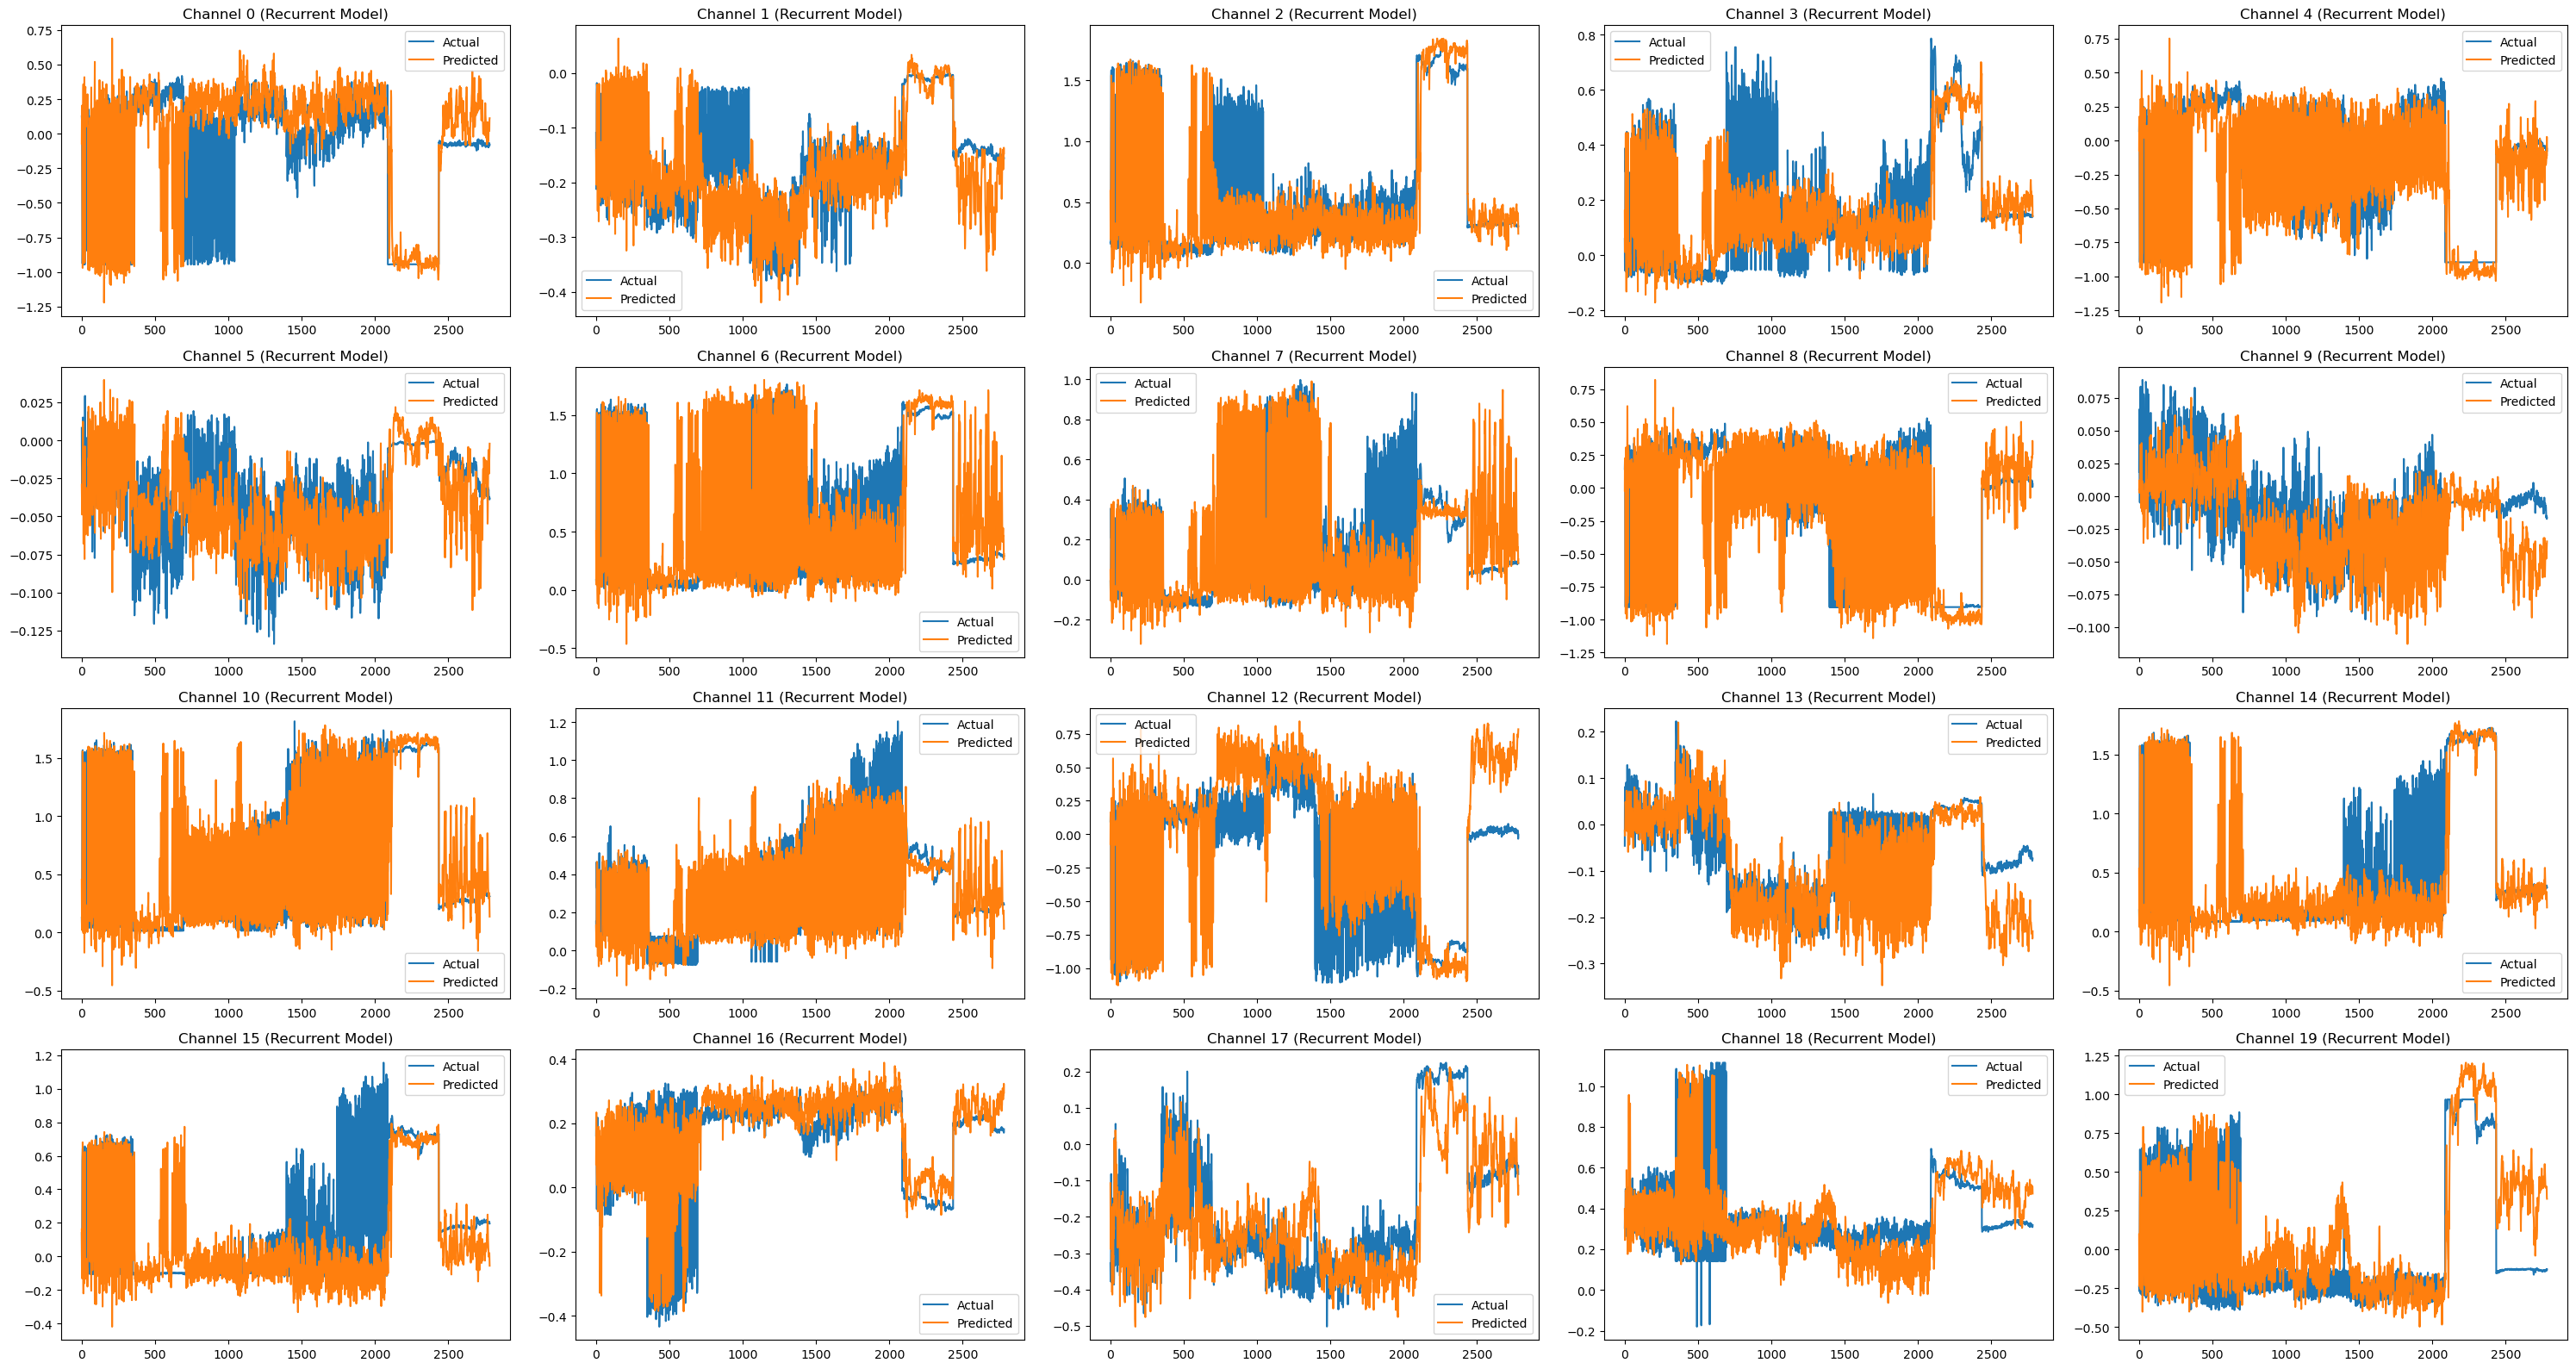

In [42]:
def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


corrs = []
r2s = []
for chan in range(y_test.shape[1]):
    y_true_chan = y_test[:, chan]
    y_pred_chan = preds_batch[:, chan]

    # Pearson correlation
    c = corrcoef(y_pred_chan, y_true_chan)
    corrs.append(c)

    # R2 score
    # если все значения y_true одинаковы, r2_score вернёт ValueError,
    # можно в этом случае руками положить 0.0
    if np.allclose(y_true_chan, y_true_chan[0]):
        r2 = 0.0
    else:
        r2 = r2_score(y_true_chan, y_pred_chan)
    r2s.append(r2)

mean_corr = np.nanmean(corrs)
mean_r2 = np.nanmean(r2s)

# вывод результатов
results = {
    "all_correlations": corrs,
    "mean_correlation": np.nanmean(corrs),
    "std_correlation": np.nanstd(corrs),
    "all_r2": r2s,
    "mean_r2": np.nanmean(r2s),
    "std_r2": np.nanstd(r2s),
}

print(
    f'  Mean correlation: {results["mean_correlation"]:.3f} ± {results["std_correlation"]:.3f}'
)
print(
    f'  Individual correlations: {[f"{c:.3f}" for c in results["all_correlations"]]}\n'
)
print(f'  Mean R2: {results["mean_r2"]:.3f} ± {results["std_r2"]:.3f}')
print(f'  Individual R2: {[f"{r2:.3f}" for r2 in results["all_r2"]]}\n')

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(30, 16))

# axs - это 4x5 массив осей
axs = axs.flatten()  # Преобразуем в 1D для удобства

for i in range(20):
    axs[i].plot(y_test[:, i])
    axs[i].plot(preds_batch[:, i])
    axs[i].set_title(f"Channel {i} (Recurrent Model)")
    axs[i].legend(["Actual", "Predicted"])

plt.tight_layout()
plt.show()

In [ ]:
estimator = "oas"
metric = "riemann"
hidden_dim = 64
seq_len = 10
num_layers = 2
dropout = 0.1
lr = 1e-3
alpha = 1e-5
max_iter = 50
batch_size = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
verbose = True

cov = Covariances(estimator="oas")
X_cov = cov.fit_transform(X_train)
ts = TangentSpace(metric="riemann")
X_ts = ts.fit_transform(X_cov)

X_seq, y_seq = prepare_sequences(X_ts, y_train, seq_len)

dataset = TensorDataset(
    torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

feat_dim = X_ts.shape[1]
output_dim = y_train.shape[1]

model_ = EMGDecoderLSTM(feat_dim, hidden_dim, output_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_.parameters(), lr=lr, weight_decay=alpha)

model_.train()

Xb, yb = next(iter(loader))
Xb, yb = Xb.to(device), yb.to(device)
batch_size = Xb.size(0)

prev_pred = torch.zeros(batch_size, output_dim, device=device)
hidden = None
cell = None
loss_batch = 0.0

for t in range(seq_len):
    feat_t = Xb[:, t, :]
    target_t = yb[:, t, :]

    pred_t, hidden, cell = model_.forward_step(feat_t, prev_pred, hidden, cell)
    loss_batch += criterion(pred_t, target_t)
    prev_pred = target_t.detach()

In [107]:
X_cov = cov.transform(X_test)
X_ts = ts.transform(X_cov)  # (T, feat_dim)
X_ts = torch.tensor(X_ts, dtype=torch.float32).to(device)

model_.eval()
preds = []
prev_pred = torch.zeros(1, model_.output_dim, device=device)
hidden = None
cell = None

with torch.no_grad():
    for feat in X_ts:
        feat = feat.unsqueeze(0)  # (1, feat_dim)
        pred_t, hidden, cell = model_.forward_step(feat, prev_pred, hidden, cell)
        preds.append(pred_t.cpu().numpy().ravel())
        prev_pred = pred_t